In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras import models, layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import time

# Import Data

In [2]:
# all_data = pd.read_csv('w207_final_project_hold/data/icml_face_data.csv')
all_data = pd.read_csv('../input/facial-expression-recognition-challenge/icml_face_data.csv/icml_face_data.csv')
# all_data = all_data[0:700] # just for dev... remove for actual training
print(all_data.shape)
# all_data = all_data.sample(n=10000, random_state=1)

accuracy = {}
params = {}

(35887, 3)


# Preprocessing

In [3]:
all_data.rename({' Usage': 'Usage', ' pixels': 'pixels'}, axis=1, inplace=True)

In [4]:
def pixels_to_arr(pixels):
    array = np.array(pixels.split(),'float64')
    return array

all_data['pixels_arr'] = all_data['pixels'].apply(pixels_to_arr)

## Grouping the emotions

In [5]:
all_data.loc[all_data['emotion'].isin([0,1,4]), 'emotion_group'] = 0 #'Angry/Sad'
all_data.loc[all_data['emotion'].isin([2,5]), 'emotion_group'] = 1 #'Fear/Surprise'
all_data.loc[all_data['emotion'] == 3, 'emotion_group'] = 2 #'Happy'
all_data.loc[all_data['emotion'] == 6, 'emotion_group'] = 3 #'Neutral'

In [6]:
def image_reshape(data):
    image = np.reshape(data['pixels_arr'].to_list(),(data.shape[0],48,48,1))/255
    return image

X = image_reshape(all_data)
y = all_data['emotion']
y_group = all_data['emotion_group']

## Split

In [7]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X, y_group, test_size=0.2, random_state=12345)
X_train_im, X_val_im, y_train_im, y_val_im = train_test_split(X_train_im, y_train_im, test_size=0.25, random_state=1)

print("Converted Images")
print("Training data shape: ", X_train_im.shape)
print("Test data shape", X_test_im.shape)
print("Validation data shape", X_val_im.shape)

Converted Images
Training data shape:  (21531, 48, 48, 1)
Test data shape (7178, 48, 48, 1)
Validation data shape (7178, 48, 48, 1)


In [8]:
train_labels = to_categorical(y_train_im)
val_labels = to_categorical(y_test_im)
test_labels = to_categorical(y_val_im)

In [9]:
classes = dict(zip(range(0, 4), (((all_data[all_data['Usage']=='Training']['emotion_group'].value_counts()).sort_index())/len(all_data[all_data['Usage']=='Training']['emotion_group'])).tolist()))

# Function to create model
## Need this to use Keras Classifier and GridSearch

In [10]:
def create_model(): 
    model_cnn = models.Sequential()
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dense(4, activation='softmax'))
    model_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_cnn

# Define parameters for grid search and training model


In [11]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [1, 2, 3, 4, 5, 10, 25, 50]
}

model_test = KerasClassifier(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model_test, param_grid=param_grid, cv=5)#, scoring="accuracy")
grid_result = grid.fit(X, to_categorical(y_group))  


2021-12-08 02:11:32.396490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 02:11:32.494774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 02:11:32.495488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 02:11:32.497027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

225/225 [==============================] - 1s 2ms/step - loss: 1.0884 - accuracy: 0.5245
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.1980 - accuracy: 0.4565
Epoch 2/2
225/225 [==============================] - 1s 3ms/step - loss: 0.9872 - accuracy: 0.5855
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.2081 - accuracy: 0.4500
Epoch 2/2
225/225 [==============================] - 1s 2ms/step - loss: 1.0059 - accuracy: 0.5793
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.2218 - accuracy: 0.4437
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.0006 - accuracy: 0.5809
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.1909 - accuracy: 0.4611
Epoch 2/2
225/225 [==============================] - 1s 2ms/step - loss: 0.9277 - accuracy: 0.6110
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.1762 - accuracy: 0.4737
Epoch 2/2
225/225 [=

In [12]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.634409 using {'batch_size': 64, 'epochs': 10}


# Taking best parameters from grid search and properly training

In [13]:
best_params = grid_result.best_params_

final_model = create_model()

history = final_model.fit(X_train_im, train_labels,
                    validation_data=(X_val_im, val_labels),
                    class_weight = classes,
                    epochs = best_params['epochs'],
                    batch_size = best_params['batch_size'])
final_model.summary()

Epoch 1/10
337/337 [==============================] - 3s 7ms/step - loss: 0.3151 - accuracy: 0.4150 - val_loss: 1.7161 - val_accuracy: 0.2894
Epoch 2/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2675 - accuracy: 0.5314 - val_loss: 1.7307 - val_accuracy: 0.2934
Epoch 3/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2437 - accuracy: 0.5820 - val_loss: 1.9617 - val_accuracy: 0.2926
Epoch 4/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2265 - accuracy: 0.6150 - val_loss: 2.0311 - val_accuracy: 0.2938
Epoch 5/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2124 - accuracy: 0.6387 - val_loss: 2.1130 - val_accuracy: 0.2867
Epoch 6/10
337/337 [==============================] - 2s 6ms/step - loss: 0.1996 - accuracy: 0.6648 - val_loss: 2.4011 - val_accuracy: 0.2896
Epoch 7/10
337/337 [==============================] - 2s 6ms/step - loss: 0.1867 - accuracy: 0.6900 - val_loss: 2.3824 - val_accuracy: 0.2933
Epoch 

In [14]:
test_prob = final_model.predict(X_test_im)
y_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(y_pred == y_test_im)

print(test_accuracy)

0.6221788799108386


# Visualization

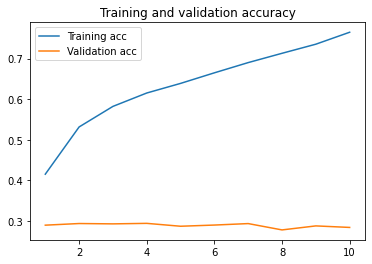

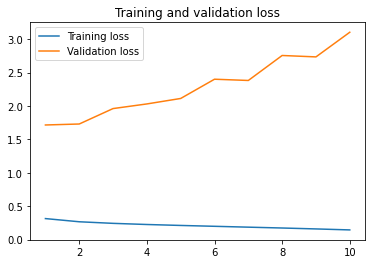

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()